# Подготовка данных
Все пункты в первом разделе необходимо запустить для настройки и создания необходимых процедур. Разделы содержат пояснения по данным

## Подключения и настройки

### Подключения

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
from scipy import stats
%matplotlib inline
import statistics
import seaborn as sns
import locale
import gc
import retentioneering

### Настройки

In [2]:
pd.options.display.float_format ='{:.2f}'.format
pd.plotting.register_matplotlib_converters()
locale.setlocale(locale.LC_ALL, 'ru_RU.UTF-8');
pd.options.display.max_columns = None
retentioneering.config.update({
    'user_col': 'client_id',
    'event_col':'event_name',
    'event_time_col':'event_dttm',
})

### Дополнительные процедуры

#### Truedescribe
Получает на вход dataframe и описывает его чуть более понятно, чем describe.

Дополняет описание гистрограммами распределения, общим описанием, типами данных колонок, суммой, выборкой первых и последних vals сортированных значений колонки, а также vals случайных строкб а также описаниями из dspt.

In [3]:
def truedescribe (dftd, vals=3, dspt=None):
    dftd=dftd.copy()
    dfcolumns=dftd.columns
    l=1
# строим гистограммы распределения всех столбцов, кроме текстовых и временной разницы
    headers=dftd.select_dtypes(exclude=['object', 'timedelta64']).columns
    for i in headers:
        l+=1
        plt.subplot(1, len(headers)+1, l)
        if (dftd[i].dtypes=='bool'):
            dftd[i].astype(int).hist(figsize=(20,4), label=i)
        else:
            dftd[i].hist(figsize=(20,4), label=i)
        plt.title(i)
# выводим общие характеристики датафрейма
    print('{:n} rows X '.format(len(dftd)),len(dfcolumns),'columns X {:n}'.format(dftd.size), 'items X {:n}'.format(sum(dftd.count())),'nonnull items X {:n}'.format(dftd.memory_usage(deep=True).sum()/1024),' Kbytes')
# выводим количество колонок разных типов
    print(dftd.dtypes.value_counts().to_string())
# берём стандартную функцию описания столбцов датафрейма, чтобы выбрать/заменить/дополнить параметры
    dscb=dftd.describe(include='all', datetime_is_numeric=True)
# доля непустых значений в столбце
    dscb.loc['nonnull%']=dftd.agg("count")/len(dftd)*100
# тип данных в столбце
    dscb.loc['dtype']=dftd.dtypes
# сумма в столбце
    dscb.loc['sum']=dftd.sum(numeric_only=True)
# медиана в столбце
    dscb.loc['median']=dftd.median(numeric_only=True)
    dscb=pd.concat([dscb,dspt], join='inner')
# меняем порядок характеристик столбцов и отбираем их
    dscb = dscb.reindex(index = ['desc', 'category', 'dtype','nonnull%','count', 'unique', 'mean', 'median', 'top', 'freq', 'sum'])
    dftd1  = pd.DataFrame()
    dftd2  = pd.DataFrame()
# по каждому столбцу добавляем
    for col in dfcolumns:
# первые vals отсортированных по порядку значений без пустых ячеек (первое эквивалентно минимальному)
        dftd1[col]=dftd[col].sort_values(ignore_index=True,ascending=True,na_position='last').head(vals)
# последние vals отсортированных по порядку значений без пустых ячеек (последнее эквивалентно максимальному)
        dftd2[col]=dftd[col].sort_values(ignore_index=True,ascending=True,na_position='first').tail(vals)
# заменяем стандартное колничество уникальных значений, которое плохо тем, что не рассчитывается для чисел
        dscb.loc['unique', col]=dftd[col].nunique()
        if (dscb.loc['dtype', col]=='datetime64[ns]'): 
            dscb.loc['median', col]=dftd[col].quantile(0.5, interpolation="midpoint")
        if (dscb.loc['dtype', col]=='timedelta64[ns]'): 
            dscb.loc['median', col]=dftd[col].quantile(0.5, interpolation="midpoint")
    dscb=[dscb,dftd1.set_index('asc_'+dftd1.index.astype(str)),dftd2.set_index('asc_'+dftd2.index.astype(str)).sort_index(ascending=False)]
# добавляем vals случайных строк из датасета
    for i in range(vals):
        t=dftd.sample()
        dscb.append(t.set_index('rnd_'+t.index.astype(str)))
    dscb=pd.concat(dscb)
    del dftd
    return dscb

## Загрузка и осмотр данных
### Загрузка
Загрузим данные, перед этим вспомнм описание:


| **Название полей**                 | **Описание**                                                                                      | **Категория**                  | **Описание данных**                                                                                                                                                                                                                                  |
| ------------------------------ | --------------------------------------------------------------------------------------------- | -------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| event\_name                    | событие                                                                                       | Данные по поведению юзеров | obj                                                                                                                                                                                                                                              |
| event\_dttm                    | дата и время события                                                                          | Данные по поведению юзеров | 18.09.21-17.10.21-23.11.21                                                                                                                                                                                                                       |
| client\_id                     | уникальный идентификатор пользователя                                                         | Свойства пользователей     | 100000;115969                                                                                                                                                                                                                                    |
| client\_creationdate           | дата создания пользователя                                                                    | Свойства пользователей     | 27.01.16-29.09.21-31.10.21                                                                                                                                                                                                                       |
| admin\_status                  | статус администратора пользователя                                                            | Свойства пользователей     | 1st admin, other admin. 1st\_admin- пользователь, который зарегистрировал аккаунт                  |
| country\_group                 | регион пользователя                                                                           | Свойства пользователей     | Asia, South America, Europe, North America, United States, Russian Speaking Countries, Africa, Other                                                                                                                                             |
| support\_provided              | была ли предоставлена поддержка пользователю                                                  | Свойства пользователей     | True/False                                                                                                                                                                                                                                       |
| traffic\_source                | источник траффика пользователя                                                                | Свойства пользователей     | Organic, Unknown, Search, Referral, Social Media                                                                                                                                                                                                 |
| first\_device\_type\_of\_user  | устройство, с которого была произведена регистрация                                           | Свойства пользователей     | Android, Desktop, iOS                                                                                                                                                                                                                            |
| hear\_source                   | откуда пользователь узнал про платформу                                                       | Свойства пользователей     | Recommended by friend or colleague, Social media, Search Engine, Other, Blog or publication                                                                                                                                                      |
| account\_creationdate          | дата создания аккаунта                                                                        | Свойства ботов             | 11.05.16-05.10.21-31.10.21                                                                                                                                                                                                                       |
| account\_id                    | уникальный идентификатор аккаунта                                                             | Свойства ботов             | 1;17560                                                                                                                                                                                                                                          |
| industry                       | сфера деятельности аккаунта                                                                   | Свойства ботов             | Other, Personal blog, Infopreneurship, Local business or place, E-commerce, Unknown, Celebrity, Artist or Public Figure, Professional consulting, Hotel and hospitality, Organisation or institution, Fun (jokes, community, daily quotes, etc.) |
| initial\_channel               | первый зарегистрированный канал у аккаунта                                                    | Свойства ботов             | IG, FB, Other                                                                                                                                                                                                                                    |
| first\_account\_for\_user      | является ли аккаунт первым у пользователя                                                     | Свойства ботов             | True/False                                                                                                                                                                                                                                       |
| current\_account\_status       | платежный статус аккаунта на данный момент                                                    | Свойства ботов             | free, expired, pro, blocked, vip, trial\_pro                                                                                                                                                                                                     |
| ig\_followerscount             | количество подписчиков в Instagram у аккаунта                                                 | Свойства ботов             | 0;11681862                                                                                                                                                                                                                                       |
| ig\_enable\_dttm               | дата подключения Instagram канала                                                             | Свойства ботов             | 18.09.21-10.10.21-31.10.21                                                                                                                                                                                                                       |
| ig\_activation\_dttm           | дата активации Instagram канала                                                               | Свойства ботов             | 18.09.21-20.10.21-16.11.21                                                                                                                                                                                                                       |
| first\_ig\_flow\_publish\_dttm | дата публикации первого чат-бота в Instagram                                                  | Свойства ботов             | 18.09.21-17.10.21-16.11.21                                                                                                                                                                                                                       |
| trial\_dttm                    | дата подключения trial версии платформы                                                       | Свойства ботов             | 11.05.21-10.10.21-15.11.21                                                                                                                                                                                                                       |
| paid\_dttm                     | дата первой оплаты подписки                                                                   | Свойства ботов             | 22.12.16-16.10.21-14.11.21                                                                                                                                                                                                                       |
| pro\_dttm                      | дата доступа к pro-функциональности                                                           | Свойства ботов             | 22.12.16-12.10.21-14.11.21                                                                                                                                                                                                                       |
| ltv\_predicted                 | новое поле от ML отдела, предсказанный LTV                                                    | Свойства ботов             | \-9999;14998                                                                                                                                                                                                                                     |

In [193]:
def load_ds():
    ds = pd.read_csv("Dataset for Career Factory 22032022.zip", parse_dates=['event_dttm','client_creationdate', 'account_creationdate', 'ig_enable_dttm', 'ig_activation_dttm', 'first_ig_flow_publish_dttm', 'trial_dttm', 'paid_dttm', 'pro_dttm'])
    #869 278 -> 857 708, 1,33%
    ds.dropna(subset=['event_dttm', 'event_name'],inplace=True)
    ds=ds[ds['client_creationdate'] > '2021-09-18 00:00:00']
    #ds.dropna(subset=['ig_followerscount', 'country_group', 'client_creationdate', 'event_dttm', 'event_name', 'account_creationdate', 'current_account_status'],inplace=True)
    #ds.ig_followerscount=ds.ig_followerscount.astype('int64')
    return ds
ds=load_ds()

# описания столбцов из документации для вывода в таблице-описании
dspt = pd.DataFrame(np.array([['Данные по поведению юзеров' ,'Данные по поведению юзеров' ,'Свойства пользователей' ,'Свойства пользователей' ,'Свойства пользователей' ,'Свойства пользователей' ,'Свойства пользователей' ,'Свойства пользователей' ,'Свойства пользователей' ,'Свойства пользователей' ,'Свойства ботов' ,'Свойства ботов' ,'Свойства ботов' ,'Свойства ботов' ,'Свойства ботов' ,'Свойства ботов' ,'Свойства ботов' ,'Свойства ботов' ,'Свойства ботов' ,'Свойства ботов' ,'Свойства ботов' ,'Свойства ботов' ,'Свойства ботов' ,'Свойства ботов'], ['событие' ,'дата и время события' ,'уникальный идентификатор пользователя' ,'дата создания пользователя' ,'статус администратора пользователя' ,'регион пользователя' ,'была ли предоставлена поддержка пользователю' ,'источник траффика пользователя' ,'устройство, с которого была произведена регистрация' ,'откуда пользователь узнал про платформу' ,'дата создания аккаунта' ,'уникальный идентификатор аккаунта' ,'сфера деятельности аккаунта' ,'первый зарегистрированный канал у аккаунта' ,'является ли аккаунт первым у пользователя' ,'платежный статус аккаунта на данный момент' ,'количество подписчиков в Instagram у аккаунта' ,'дата подключения Instagram канала' ,'дата активации Instagram канала' ,'дата публикации первого чат-бота в Instagram' ,'дата подключения trial версии платформы' ,'дата первой оплаты подписки' ,'дата доступа к pro-функциональности' ,'новое поле от ML отдела, предсказанный LTV']]), columns=['event_name', 'event_dttm', 'client_id', 'client_creationdate', 'admin_status', 'country_group', 'support_provided', 'traffic_source', 'first_device_type_of_user', 'hear_source', 'account_creationdate', 'account_id', 'industry', 'initial_channel', 'first_account_for_user', 'current_account_status', 'ig_followerscount', 'ig_enable_dttm', 'ig_activation_dttm', 'first_ig_flow_publish_dttm', 'trial_dttm', 'paid_dttm', 'pro_dttm', 'ltv_predicted'], index=['category', 'desc'])

ds=ds.reindex(columns = dspt.columns)

# выводим общие характеристики датафрейма
print('{:n} rows X '.format(len(ds)),len(ds.columns),'columns X {:n}'.format(ds.size), 'items X {:n}'.format(sum(ds.count())),'nonnull items X {:n}'.format(ds.memory_usage(deep=True).sum()/1024),' Kbytes')
# выводим количество колонок разных типов
print(ds.dtypes.value_counts().to_string())

566 598 rows X  24 columns X 13 598 352 items X 11 627 129 nonnull items X 405 199  Kbytes
object            9
datetime64[ns]    9
int64             3
bool              2
float64           1


### Осмотр исходных данных 
Так как колонок много, рассмотрим их в разбивке по типам
#### Текстовые данные

In [183]:
truedescribe (ds.select_dtypes(exclude=['int64','bool','datetime64', 'float64']) , 1, dspt)
#truedescribe (ds[ds['event_name'].isnull()].select_dtypes(exclude=['int64','bool','datetime64', 'float64']) , 3, dspt)

566 622 rows X  9 columns X 5 099 598 items X 5 094 384 nonnull items X 346 560  Kbytes
object    9


,event_name,admin_status,country_group,traffic_source,first_device_type_of_user,hear_source,industry,initial_channel,current_account_status
desc,событие,статус администратора пользователя,регион пользователя,источник траффика пользователя,"устройство, с которого была произведена регист...",откуда пользователь узнал про платформу,сфера деятельности аккаунта,первый зарегистрированный канал у аккаунта,платежный статус аккаунта на данный момент
category,Данные по поведению юзеров,Свойства пользователей,Свойства пользователей,Свойства пользователей,Свойства пользователей,Свойства пользователей,Свойства ботов,Свойства ботов,Свойства ботов
dtype,object,object,object,object,object,object,object,object,object
nonnull%,100.00,100.00,99.09,100.00,100.00,100.00,100.00,100.00,99.99
count,566598,566622,561471,566622,566622,566622,566622,566622,566583
unique,586,2,8,4,3,5,11,3,6
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
median,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,web.interface.dashboard.page_view,1st admin,South America,Unknown,Desktop,Recommended by friend or colleague,Unknown,IG,free
freq,43403,563915,212355,362825,378060,176213,117253,424949,369292


#### Числовые данные

566 622 rows X  4 columns X 2 266 488 items X 2 266 488 nonnull items X 22 133,7  Kbytes
int64      3
float64    1


,client_id,account_id,ig_followerscount,ltv_predicted
desc,уникальный идентификатор пользователя,уникальный идентификатор аккаунта,количество подписчиков в Instagram у аккаунта,"новое поле от ML отдела, предсказанный LTV"
category,Свойства пользователей,Свойства ботов,Свойства ботов,Свойства ботов
dtype,int64,int64,float64,int64
nonnull%,100.00,100.00,100.00,100.00
count,566622.00,566622.00,566622.00,566622.00
unique,11175,11880,4774,9499
mean,106641.46,7354.25,7896.23,2398.25
median,105994.00,6628.00,621.00,2073.00
top,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN


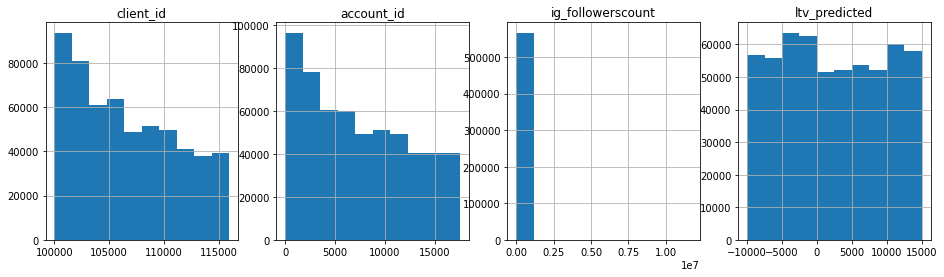

In [184]:
truedescribe (ds.select_dtypes(exclude=['object','bool','datetime64']) , 1, dspt)

#### Даты

566 622 rows X  9 columns X 5 099 598 items X 3 133 445 nonnull items X 44 267,3  Kbytes
datetime64[ns]    9


,event_dttm,client_creationdate,account_creationdate,ig_enable_dttm,ig_activation_dttm,first_ig_flow_publish_dttm,trial_dttm,paid_dttm,pro_dttm
desc,дата и время события,дата создания пользователя,дата создания аккаунта,дата подключения Instagram канала,дата активации Instagram канала,дата публикации первого чат-бота в Instagram,дата подключения trial версии платформы,дата первой оплаты подписки,дата доступа к pro-функциональности
category,Данные по поведению юзеров,Свойства пользователей,Свойства ботов,Свойства ботов,Свойства ботов,Свойства ботов,Свойства ботов,Свойства ботов,Свойства ботов
dtype,datetime64[ns],datetime64[ns],datetime64[ns],datetime64[ns],datetime64[ns],datetime64[ns],datetime64[ns],datetime64[ns],datetime64[ns]
nonnull%,100.00,100.00,99.99,100.00,25.39,53.58,29.31,13.47,31.26
count,566622,566622,566583,566622,143855,303608,166064,76317,177152
unique,566616,11175,11878,11880,3476,7483,2732,1225,2990
mean,2021-10-15 00:04:09.557150976,2021-10-10 03:18:11.961104128,2021-10-10 17:24:02.467749888,2021-10-11 11:52:34.047894016,2021-10-18 16:32:25.893218560,2021-10-14 20:16:06.267093248,2021-10-13 05:51:13.696733184,2021-10-20 10:49:04.864905728,2021-10-14 04:47:49.288475392
median,2021-10-17 14:43:05.760571392,2021-10-11 12:01:07.132236032,2021-10-12 01:18:21.949655040,2021-10-12 23:45:21.376228096,2021-10-20 13:46:37.943442944,2021-10-18 18:35:12.455781888,2021-10-13 18:24:51.986296064,2021-10-22 00:27:39,2021-10-17 17:56:21
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


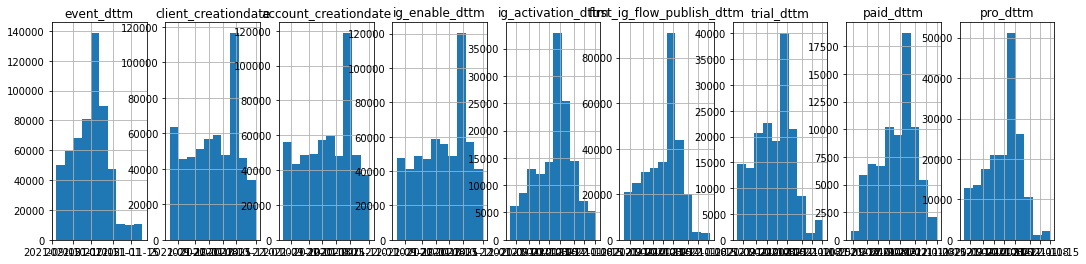

In [185]:
truedescribe (ds.select_dtypes(exclude=['object','bool','int64', 'float64']) , 1, dspt)

#### Булевы типы

566 622 rows X  2 columns X 1 133 244 items X 1 133 244 nonnull items X 5 533,42  Kbytes
bool    2


,support_provided,first_account_for_user
desc,была ли предоставлена поддержка пользователю,является ли аккаунт первым у пользователя
category,Свойства пользователей,Свойства ботов
dtype,bool,bool
nonnull%,100.00,100.00
count,566622,566622
unique,2,2
mean,NaN,NaN
median,0.00,1.00
top,False,True
freq,558069,514626


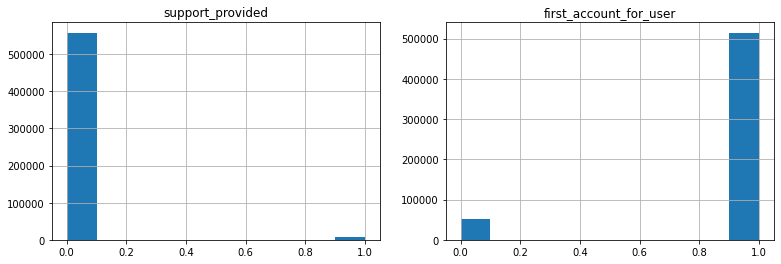

In [186]:
truedescribe (ds.select_dtypes(exclude=['int64','object','datetime64', 'float64']) , 1, dspt)

## Дополнение данных

### Генерация событий из дат пользователей и ботов
Из исследования ручного исследования данных в Power BI видно, что соотношение account_id бота и client_id пользователя – многие-к-одному. При этом client_id не определяет admin_status  и hear_source – это по сути свойства бота. Свойство account_id бота определяет все поля, кроме данных по поведению пользователей. Данные об активации не содержатся в исходных данных. Из 7 дат ботов (17 560) и клиентов можно сгенерировать события 7 типов (вех воронки) и обогатить данные 53 557 событиями.

Закомментировано после исследований

570 074 rows X  24 columns X 13 681 776 items X 11 704 123 nonnull items X 407 620  Kbytes
object            9
datetime64[ns]    9
int64             3
bool              2
float64           1


,event_name,event_dttm,client_id,client_creationdate,admin_status,country_group,support_provided,traffic_source,first_device_type_of_user,hear_source,account_creationdate,account_id,industry,initial_channel,first_account_for_user,current_account_status,ig_followerscount,ig_enable_dttm,ig_activation_dttm,first_ig_flow_publish_dttm,trial_dttm,paid_dttm,pro_dttm,ltv_predicted
desc,событие,дата и время события,уникальный идентификатор пользователя,дата создания пользователя,статус администратора пользователя,регион пользователя,была ли предоставлена поддержка пользователю,источник траффика пользователя,"устройство, с которого была произведена регист...",откуда пользователь узнал про платформу,дата создания аккаунта,уникальный идентификатор аккаунта,сфера деятельности аккаунта,первый зарегистрированный канал у аккаунта,является ли аккаунт первым у пользователя,платежный статус аккаунта на данный момент,количество подписчиков в Instagram у аккаунта,дата подключения Instagram канала,дата активации Instagram канала,дата публикации первого чат-бота в Instagram,дата подключения trial версии платформы,дата первой оплаты подписки,дата доступа к pro-функциональности,"новое поле от ML отдела, предсказанный LTV"
category,Данные по поведению юзеров,Данные по поведению юзеров,Свойства пользователей,Свойства пользователей,Свойства пользователей,Свойства пользователей,Свойства пользователей,Свойства пользователей,Свойства пользователей,Свойства пользователей,Свойства ботов,Свойства ботов,Свойства ботов,Свойства ботов,Свойства ботов,Свойства ботов,Свойства ботов,Свойства ботов,Свойства ботов,Свойства ботов,Свойства ботов,Свойства ботов,Свойства ботов,Свойства ботов
dtype,object,datetime64[ns],int64,datetime64[ns],object,object,bool,object,object,object,datetime64[ns],int64,object,object,bool,object,float64,datetime64[ns],datetime64[ns],datetime64[ns],datetime64[ns],datetime64[ns],datetime64[ns],int64
nonnull%,100.00,100.00,100.00,100.00,100.00,99.09,100.00,100.00,100.00,100.00,99.99,100.00,100.00,100.00,100.00,99.99,100.00,100.00,25.84,53.87,29.40,13.53,31.36,100.00
count,570074,570074,570074.00,570074,570074,564901,570074,570074,570074,570074,570033,570074.00,570074,570074,570074,570033,570074.00,570074,147331,307080,167620,77140,178801,570074.00
unique,587,570068,11175,11175,2,8,2,4,3,5,11878,11880,11,3,2,6,4774,11880,3476,7483,2732,1225,2990,9499
mean,NaN,2021-10-15 00:26:37.191378176,106649.57,2021-10-10 03:26:43.835431424,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-10 17:33:48.296747008,7364.30,NaN,NaN,NaN,NaN,7948.98,2021-10-11 11:57:43.398131712,2021-10-18 16:03:05.400757760,2021-10-14 19:45:37.273040384,2021-10-13 05:40:13.289434368,2021-10-20 10:45:57.809541376,2021-10-14 04:33:48.680935424,2397.94
median,NaN,2021-10-17 15:01:30.900165120,106014.00,2021-10-11 12:11:41.400089088,NaN,NaN,0.00,NaN,NaN,NaN,2021-10-12 02:36:23.808380928,6629.00,NaN,NaN,1.00,NaN,628.00,2021-10-12 23:45:21.376228096,2021-10-20 13:37:09.253462016,2021-10-18 18:22:56.977559040,2021-10-13 17:37:54.243148032,2021-10-21 23:14:31,2021-10-17 17:33:54,2073.00
top,web.interface.dashboard.page_view,NaN,NaN,NaN,1st admin,South America,False,Unknown,Desktop,Recommended by friend or colleague,NaN,NaN,Unknown,IG,True,free,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,43403,NaN,NaN,NaN,567354,214158,561471,365112,380416,177240,NaN,NaN,117912,427975,517728,371030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


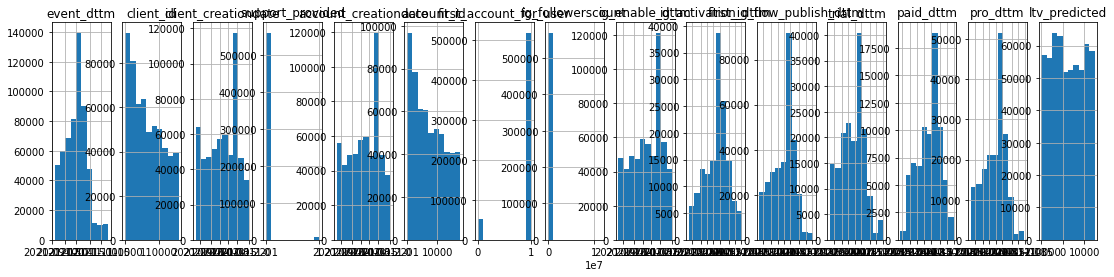

In [194]:
bots=ds.drop(columns=['event_name','event_dttm']).drop_duplicates()

t  = [ds]
newevents={'ig_activation':'ig_activation_dttm'}#, 'account_creation':'account_creationdate', 'ig_enable':'ig_enable_dttm', 'first_ig_flow_publish':'first_ig_flow_publish_dttm', 'trial':'trial_dttm', 'paid':'paid_dttm', 'pro':'pro_dttm'}
for ev in newevents:
    ev1=bots.dropna(subset=[newevents[ev]]).copy()
    ev1['event_name']=ev
    ev1['event_dttm']=ev1.loc[:, newevents[ev]]
    t.append(ev1[ev1['event_dttm'] > '2021-09-18 00:00:00'])
ds=pd.concat(t)
#удалим сгенерированные события подписки на pro, когда менее через 5 секунд после них подключается trial
#ds=ds[~((ds['event_name']=="pro")&((ds['trial_dttm']-ds['pro_dttm']).dt.total_seconds()<5))]
#удалим сгенерированные события подписки на pro, когда они происходят после оплаты
#ds=ds[~((ds['event_name']=="pro")&((ds['paid_dttm']-ds['pro_dttm']).dt.total_seconds()<5))]
truedescribe(ds,1,dspt)

### Разметка сессиями

570 074 rows X  5 columns X 2 850 370 items X 2 850 370 nonnull items X 24 495,4  Kbytes
int64      3
float64    1
int32      1


,client_id,account_id,ig_followerscount,ltv_predicted,session
desc,NaN,NaN,NaN,NaN,NaN
category,NaN,NaN,NaN,NaN,NaN
dtype,int64,int64,float64,int64,int32
nonnull%,100.00,100.00,100.00,100.00,100.00
count,570074.00,570074.00,570074.00,570074.00,570074.00
unique,11175,11880,4774,9499,175
mean,106649.57,7364.30,7948.98,2397.94,3.74
median,106014.00,6629.00,628.00,2073.00,1.00
top,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN


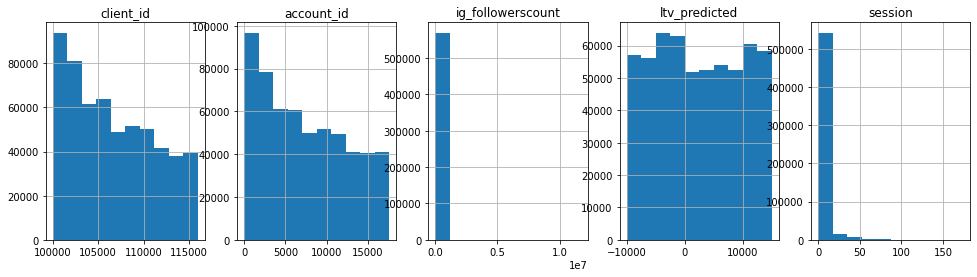

In [195]:
ds = ds.sort_values('event_dttm')
ds['session'] = (ds.groupby('client_id')['event_dttm'].transform(lambda x: (x.diff() > '00:30:00').cumsum()))
truedescribe (ds.select_dtypes(exclude=['object','bool','datetime64']) , 1)

### Добавление колонки с номером сессией активации

In [196]:
activations = ds[ds['event_name']=='ig_activation'][['account_id', 'session']].rename(columns={"session": "session_activation"})
ds=ds.merge(activations, how='left', on='account_id')
ds['session_activation'].value_counts()

1.00     62091
2.00     24623
3.00     18656
4.00     10420
5.00      7872
6.00      6147
8.00      2728
7.00      2700
0.00      2323
10.00     1905
9.00      1651
12.00     1475
17.00      653
15.00      611
19.00      481
28.00      479
13.00      424
38.00      384
20.00      339
18.00      290
27.00      192
25.00      192
16.00      183
22.00      176
11.00      117
29.00      115
59.00       53
14.00       51
Name: session_activation, dtype: int64

### Выгрузка для внешнего анализа (Power BI)

In [197]:
ds.to_csv('dshard.csv')

# Сегментация

## Рассмотрение поведения пользователей в сессиях
### Рассмотрим всех пользователей, которые добились активации в первую и вторую сессию и посмотрим на их поведение в обоих сессиях:

In [271]:
eventsadd=ds
eventsadd=eventsadd[(eventsadd['session_activation']<=1) & (eventsadd['session']<=1)]
retentioneering.config.update({
    'user_col': 'client_id',
    'event_col':'event_name',
    'event_time_col':'event_dttm',
})
eventsadd.rete.plot_graph(norm_type=None,
                     weight_col='client_id',
                     thresh=250,
                     targets = {'ig_activation':'green',
                                'ig_enable':'green',
                                'trial':'green',
                                'pro':'green',
                                'first_ig_flow_publish':'green',
                                'paid':'green'
                               })

'experiments/graph_2022-04-03 22_32_35_187649.html'

### Рассмотрим первую сессию пользователей, которые в ней же добились активации:

In [73]:
eventsadd=ds
eventsadd=eventsadd[(eventsadd['session_activation']==0) & (eventsadd['session']==0)]
eventsadd[['A', 'B']] = eventsadd['event_name'].str.split('.',1, expand=True)
retentioneering.config.update({
    'user_col': 'client_id',
    'event_col':'event_name',
    'event_time_col':'event_dttm',
})
eventsadd.rete.plot_graph(norm_type=None,
                     weight_col='client_id',
                     thresh=5,
                     targets = {'ig_activation':'green',
                                'ig_enable':'green',
                                'trial':'green',
                                'pro':'green',
                                'first_ig_flow_publish':'green',
                                'paid':'green'
                               })

'experiments/graph_2022-04-03 16_16_14_707103.html'

### Посмотрим, на что потратили время в первой сессии те, кто добился активации во второй: 

In [122]:
eventsadd=ds
eventsadd=eventsadd[(eventsadd['session_activation']==1) & (eventsadd['session']==0)]
eventsadd[['A', 'B']] = eventsadd['event_name'].str.split('.',1, expand=True)
retentioneering.config.update({
    'user_col': 'client_id',
    'event_col':'event_name',
    'event_time_col':'event_dttm',
})
eventsadd.rete.plot_graph(norm_type=None,
                     weight_col='client_id',
                     thresh=99,
                     targets = {'todo_list_item.connect_ig_account.done':'green',
                                'todo_list_item.start_trial.done':'green',
                                'web.builder.publish_success':'green',
                                'ig_activation':'green'
                               })

'experiments/graph_2022-04-03 17_34_50_587222.html'

## Кластеры
Кластеры берущих триал версию и проходящих онбординг

In [241]:
eventsadd=ds
eventsadd=eventsadd[(eventsadd['session']==0)&(eventsadd['session_activation']>=0)]
#eventsadd['ig_activation'] = np.where(eventsadd['ig_activation_dttm'].isnull(), 0, 1)
#eventsadd['first_ig_flow_publish'] = np.where(eventsadd['first_ig_flow_publish_dttm'].isnull(), 0, 1)
retentioneering.config.update({
    'user_col': 'client_id',
    'event_col':'event_name',
    'event_time_col':'event_dttm',
})

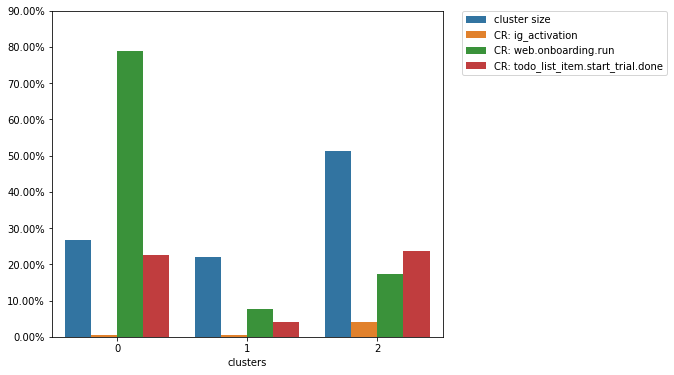

In [242]:
eventsadd.rete.get_clusters(method='kmeans',
                       feature_type='tfidf',
                       n_clusters=3,
                       ngram_range=(1,2),
                       plot_type='cluster_bar',
                       targets=['ig_activation','web.onboarding.run','todo_list_item.start_trial.done']);

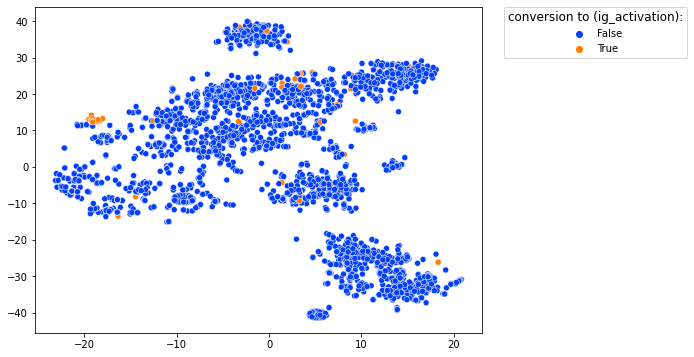

In [243]:
eventsadd.rete.project(plot_type ='targets',
                  targets=['ig_activation'],
                  method='tsne',
                  perplexity=128);

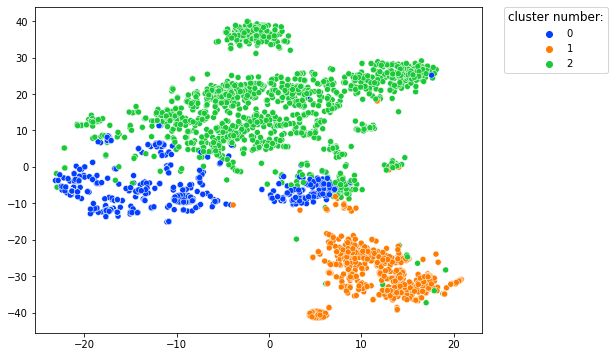

In [244]:
eventsadd.rete.project(plot_type ='clusters',
                  method='tsne',
                  perplexity=128);

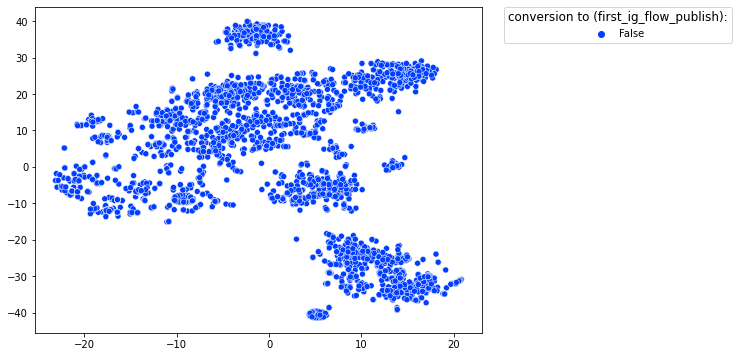

In [245]:
eventsadd.rete.project(plot_type ='targets',
                  targets = ['first_ig_flow_publish'],
                  method='tsne',
                  perplexity=128);

Кластеры дающих активации во второй сессии в сегментах прохождения онбординга и просмотра туториалов

In [272]:
eventsadd=ds
eventsadd=eventsadd[(eventsadd['session']==0)&(eventsadd['session_activation']>=1)]
#eventsadd['ig_activation'] = np.where(eventsadd['ig_activation_dttm'].isnull(), 0, 1)
#eventsadd['first_ig_flow_publish'] = np.where(eventsadd['first_ig_flow_publish_dttm'].isnull(), 0, 1)
retentioneering.config.update({
    'user_col': 'client_id',
    'event_col':'event_name',
    'event_time_col':'event_dttm',
})


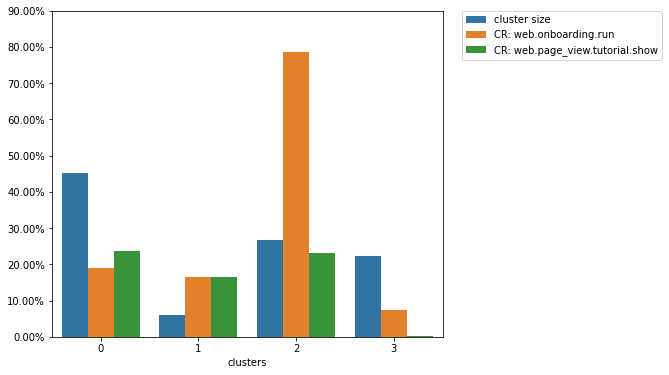

In [276]:
eventsadd.rete.get_clusters(method='kmeans',
                       feature_type='tfidf',
                       n_clusters=4,
                       ngram_range=(1,2),
                       plot_type='cluster_bar',
                       targets=['web.onboarding.run','web.page_view.tutorial.show']);

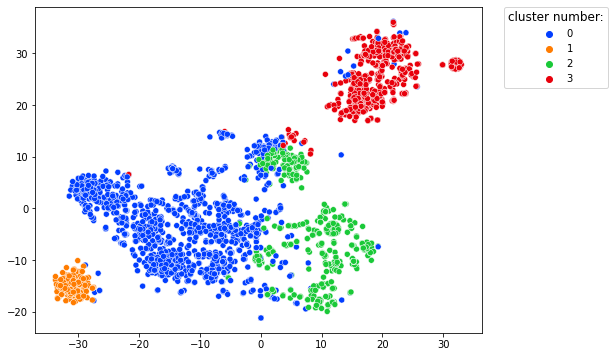

In [275]:
eventsadd.rete.project(plot_type ='clusters',
                  method='tsne',
                  perplexity=128);

In [288]:
clus_1 = eventsadd.rete.filter_cluster(3)
clus_1.rete.plot_graph(thresh=0.005,
                        targets = {'todo_list_item.connect_ig_account.done':'green',
                                'todo_list_item.start_trial.done':'green',
                                'web.builder.publish_success':'green',
                                'ig_activation':'green'
                               })

'experiments/graph_2022-04-03 23_23_31_901365.html'

## Воронки

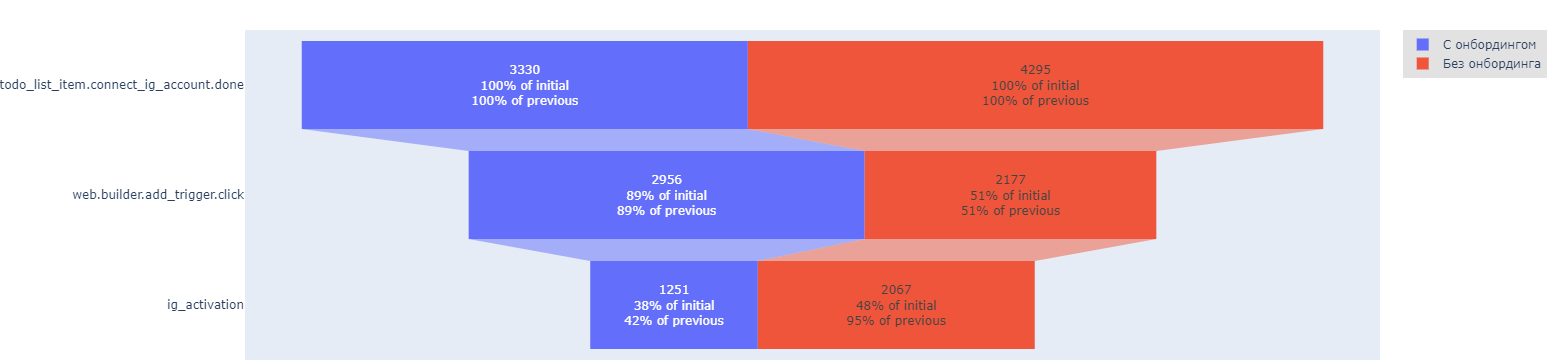

In [260]:
t=ds
g1 = set(t[t['event_name']=='web.onboarding.run']['client_id'])
g2 = set(t['client_id'])-g1
t.rete.funnel(targets = ['todo_list_item.connect_ig_account.done',  'web.builder.add_trigger.click', 'ig_activation']
                 ,groups = (g1, g2),
                 group_names = ('С онбордингом', 'Без онбординга')
              )
#[ds['session']==0]
#todo_list_item.start_trial.done

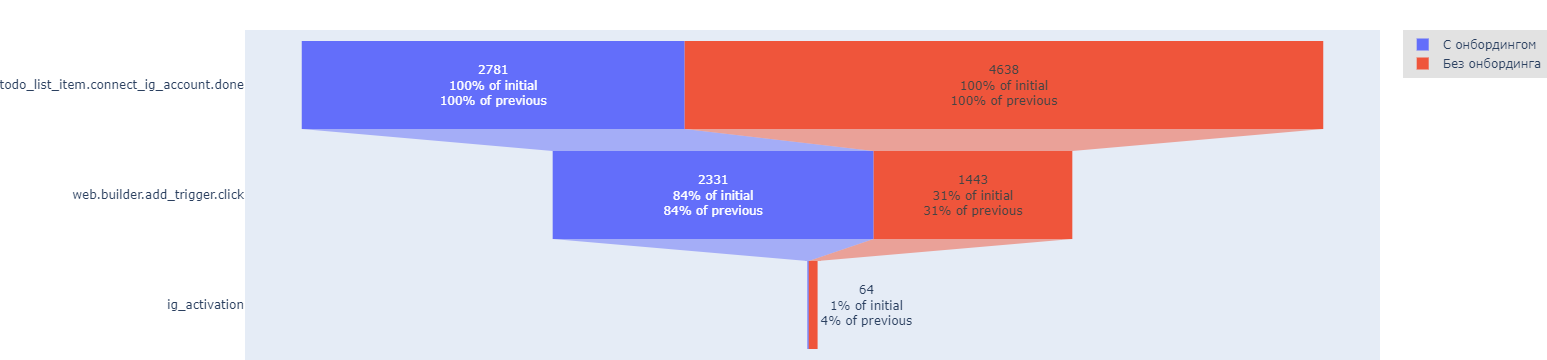

In [270]:
t=ds[(ds['session']==0) ]
g1 = set(t[t['event_name']=='web.onboarding.run']['client_id'])
g2 = set(t['client_id'])-g1
t.rete.funnel(targets = ['todo_list_item.connect_ig_account.done',  'web.builder.add_trigger.click', 'ig_activation']
                 ,groups = (g1, g2),
                 group_names = ('С онбордингом', 'Без онбординга')
              )
#[ds['session']==0]
#todo_list_item.start_trial.done

### Время на онбординг

In [222]:
t=ds[(ds['session']<=1) & (ds['session_activation']==1)]
t1=t[t['event_name']=='web.page_questionnaire.todo_list_personalization.shown'][['client_id', 'event_dttm']]
t2=t[t['event_name']=='web.builder.publish_attempt'][['client_id', 'event_dttm']]
t=t1.merge(t2, how='left', on='client_id')
t['td']=t['event_dttm_y']-t['event_dttm_x']
t['td'].median()

Timedelta('0 days 00:35:54.658559')

In [213]:
t=ds[(ds['session']<=1) & (ds['session_activation']==1)]
t1=t[t['event_name']=='web.page_questionnaire.todo_list_personalization.shown'][['client_id', 'event_dttm']]
t2=t[t['event_name']=='web.onboarding.run'][['client_id', 'event_dttm']]
t=t1.merge(t2, how='left', on='client_id')
t['td']=t['event_dttm_y']-t['event_dttm_x']
t['td'].mean()

Timedelta('0 days 00:08:41.434148284')

In [224]:
t=ds[(ds['session']<=1) & (ds['session_activation']==1)]
t1=t[t['event_name']=='web.onboarding.run'][['client_id', 'event_dttm']]
t2=t[t['event_name']=='web.builder.publish_attempt'][['client_id', 'event_dttm']]
t=t1.merge(t2, how='left', on='client_id')
t['td']=t['event_dttm_y']-t['event_dttm_x']
t['td'].mean()

Timedelta('0 days 00:26:39.601144994')